In [1]:
import pandas as pd
import numpy as np

from transformers import pipeline

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from culturally_adapted_vader import ChineseAdaptedVader  # 导入自定义类

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [2]:
# Download NLTK resources if needed
try:
    nltk.data.find('vader_lexicon')   # 检查指定资源是否存在 NLTK - VADER
except LookupError:                   # 出现 LookupError 执行代码
    nltk.download('vader_lexicon')

def load_lyrics_data(file_path):      ####
    """
    Load lyrics data from an Excel file
    """
    try:
        df = pd.read_excel(file_path)
        print(f"Data loaded successfully. Shape: {df.shape}")
        # Display basic information about the dataset
        print("\nColumns in the dataset:")
        print(df.columns.tolist())
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
def preprocess_lyrics(df, lyrics_column): 
    """
    预处理歌词文本 preprocess lyrics text
    """
    # Check if the specified column exists
    if lyrics_column not in df.columns:
        print(f"Column '{lyrics_column}' not found. Available columns: {df.columns.tolist()}")
        return None

    # Make a copy to avoid modifying the original data
    processed_df = df.copy()

    # Basic preprocessing
    processed_df['processed_lyrics'] = processed_df[lyrics_column].astype(str)      # 转换为字符串
    processed_df['processed_lyrics'] = processed_df['processed_lyrics'].str.strip() # 去除首尾空白字符

    # Remove rows with empty lyrics
    processed_df = processed_df[processed_df['processed_lyrics'] != '']             # 筛选出非空的行
    processed_df = processed_df[~processed_df['processed_lyrics'].isna()]           # 筛选出非NAN的行

    print(f"Preprocessing complete. {len(processed_df)} rows after cleaning.")
    return processed_df

In [4]:
def analyze_sentiment_vader(df, lyrics_column='processed_lyrics'):  ####
    """
    情感分析 - ① original NLTK's VADER (rule-based sentiment analysis)
    """
    sid = SentimentIntensityAnalyzer()             # 创建，初始化 VADER 分析器

    # Initialize columns for sentiment scores      # 默认值为 nan
    df['vader_compound'] = np.nan                  # 综合极性（-1 ~ +1）
    df['vader_pos'] = np.nan                       # positive
    df['vader_neg'] = np.nan                       # negative
    df['vader_neu'] = np.nan                       # neutral

    # Analyze each lyric
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Analyzing with VADER"):  # df.iterrows() 遍历每一行，返回 idx索引 row数据
        lyrics = row[lyrics_column]
        if isinstance(lyrics, str) and lyrics.strip():          # 属于(字符串)？  .strip()检查空白字符
            scores = sid.polarity_scores(lyrics)
            df.at[idx, 'vader_compound'] = scores['compound']   # .at 赋值
            df.at[idx, 'vader_pos'] = scores['pos']
            df.at[idx, 'vader_neg'] = scores['neg']
            df.at[idx, 'vader_neu'] = scores['neu']

    # Classify sentiment based on compound score
    df['vader_sentiment'] = df['vader_compound'].apply(
        lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')  # ±0.05 / ±0.1
    )

    print("Original VADER sentiment analysis complete")
    return df

In [5]:
def analyze_sentiment_cultural_vader(df, lyrics_column='processed_lyrics'):
    """
    cultural NLTK's VADER
    """
    analyzer = ChineseAdaptedVader()

    # 初始化列
    df['cultural_vader_compound'] = np.nan
    df['cultural_vader_pos'] = np.nan
    df['cultural_vader_neg'] = np.nan
    df['cultural_vader_neu'] = np.nan

    # 分析歌词
    for idx, row in tqdm(df.iterrows(), total=len(df), desc="文化适配VADER分析"):
        lyrics = row[lyrics_column]
        if isinstance(lyrics, str) and lyrics.strip():
            scores = analyzer.analyze(lyrics, cultural_context='chinese')
            df.at[idx, 'cultural_vader_compound'] = scores['compound']
            df.at[idx, 'cultural_vader_pos'] = scores['pos']
            df.at[idx, 'cultural_vader_neg'] = scores['neg']
            df.at[idx, 'cultural_vader_neu'] = scores['neu']

    # 情感分类
    df['cultural_vader_sentiment'] = df['cultural_vader_compound'].apply(
        lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral')   # ±0.05 / ±0.1
    )

    print("Chinese Adapted VADER sentiment analysis complete")
    return df

In [6]:
def analyze_sentiment_transformer(df, lyrics_column='processed_lyrics', batch_size=32):    # batch_size 每批处理的数量
    """
    情感分析 - ② Hugging Face's transformer 模型
    """
    sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

    results = []

    # 分批处理 to avoid memory issues
    lyrics_list = df[lyrics_column].tolist()          # 转为列表：将 lyrics column 转为 lyrics_list
    for i in tqdm(range(0, len(lyrics_list), batch_size), desc="Analyzing with Transformer"): # 遍历列表：从0开始，步长为 batch_size
        batch = lyrics_list[i:i+batch_size]           # 创建批次：从 i 开始，步长为 batch_size，取出一批数据
        batch = [text for text in batch if isinstance(text, str) and text.strip()]

        if batch:
            try:
                batch_results = sentiment_analyzer(batch, truncation=True)      #（truncation=True 确保 输入文本 不超过 模型最大输入长度）
                results.extend(batch_results)
            except Exception as e:
                print(f"Error in batch {i}-{i+batch_size}: {e}")
                results.extend([{'label': 'UNKNOWN', 'score': 0.0}] * len(batch))

    # Ensure results match dataframe length
    while len(results) < len(df):
        results.append({'label': 'UNKNOWN', 'score': 0.0})

    # Add results to dataframe
    df['transformer_sentiment'] = [r['label'] for r in results]
    df['transformer_score'] = [r['score'] for r in results]

    # 映射/转换 统一格式 Map to consistent format
    df['transformer_sentiment'] = df['transformer_sentiment'].map(
        {'POSITIVE': 'positive', 'NEGATIVE': 'negative', 'UNKNOWN': 'unknown'}
    )

    print("Transformer sentiment analysis complete")
    return df

In [7]:
def visualize_sentiment_distribution(df):
    """
    分数分布 Visualize the distribution of sentiment scores
    """
    plt.figure(figsize=(15, 10))

    # VADER sentiment distribution
    plt.subplot(2, 2, 1)
    sns.countplot(x='vader_sentiment', data=df)
    plt.title('VADER Sentiment Distribution')
    plt.ylabel('Count')

    # Transformer sentiment distribution
    plt.subplot(2, 2, 2)
    sns.countplot(x='transformer_sentiment', data=df)
    plt.title('Transformer Sentiment Distribution')

    # VADER compound score distribution
    plt.subplot(2, 2, 3)
    sns.histplot(df['vader_compound'], kde=True)
    plt.title('VADER Compound Score Distribution')
    plt.xlabel('Compound Score')

    # Transformer confidence score distribution
    plt.subplot(2, 2, 4)
    sns.histplot(df['transformer_score'], kde=True)
    plt.title('Transformer Confidence Score Distribution')
    plt.xlabel('Confidence Score')

    plt.tight_layout()
    plt.savefig('sentiment_distribution.png')
    plt.show()

In [8]:
def visualize_sentiment_distribution(df):
    """
    可视化三种方法的情感分布
    """
    plt.figure(figsize=(18, 12))

    # 原始VADER分布
    plt.subplot(2, 3, 1)
    sns.countplot(x='vader_sentiment', data=df)
    plt.title('Original VADER')

    # 文化适配VADER分布
    plt.subplot(2, 3, 2)
    sns.countplot(x='cultural_vader_sentiment', data=df)
    plt.title('Cultural VADER')

    # Transformer分布
    plt.subplot(2, 3, 3)
    sns.countplot(x='transformer_sentiment', data=df)
    plt.title('Transformer')

    # 分数分布对比
    plt.subplot(2, 3, 4)
    sns.kdeplot(df['vader_compound'], label='Original VADER')
    sns.kdeplot(df['cultural_vader_compound'], label='Cultural VADER')
    plt.title('Compound Score Distribution')
    plt.legend()

    plt.tight_layout()
    plt.savefig('sentiment_comparison.png')
    plt.show()

In [9]:
def compare_sentiments(df):
    """
    比较两个 VADER
    """
    # Create a comparison table
    comparison = pd.crosstab(
        df['vader_sentiment'],
        df['cultural_vader_sentiment'],
        margins=True,
        margins_name='Total'
    )

    print("Original VADER vs Chinese Adapted VADER comparison:")
    print(comparison)

    # 计算一致性  agreement percentage
    agreement1 = (df['vader_sentiment'] == df['transformer_sentiment']).mean() * 100
    agreement2 = (df['vader_sentiment'] == df['cultural_vader_sentiment']).mean() * 100
    print(f"\nAgreement between VADER and Transformer: {agreement1:.2f}%")
    print(f"\nAgreement between VADER and Cultural VADER: {agreement2:.2f}%")

    return comparison

In [10]:
def sentiment_analysis_pipeline(file_path, lyrics_column):
    """
    运行 Run the full sentiment analysis pipeline
    """
    # Load data
    df = load_lyrics_data(file_path)
    if df is None:
        return None

    # Preprocess data
    processed_df = preprocess_lyrics(df, lyrics_column)
    if processed_df is None:
        return None

    # Analyze sentiment using Original VADER
    results_df = analyze_sentiment_vader(processed_df)

    # Analyze sentiment using Chinese Adapted VADER
    results_df = analyze_sentiment_cultural_vader(results_df)

    # Analyze sentiment using transformer
    results_df = analyze_sentiment_transformer(results_df)

    # Visualize results
    visualize_sentiment_distribution(results_df)

    # Compare results
    compare_sentiments(results_df)

    return results_df

Data loaded successfully. Shape: (823, 5)

Columns in the dataset:
['id', 'title', 'artist', 'year', 'lyrics']
Preprocessing complete. 823 rows after cleaning.


Analyzing with VADER:   0%|          | 0/823 [00:00<?, ?it/s]

Original VADER sentiment analysis complete


文化适配VADER分析:   0%|          | 0/823 [00:00<?, ?it/s]

Chinese Adapted VADER sentiment analysis complete


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Analyzing with Transformer:   0%|          | 0/26 [00:00<?, ?it/s]

Transformer sentiment analysis complete


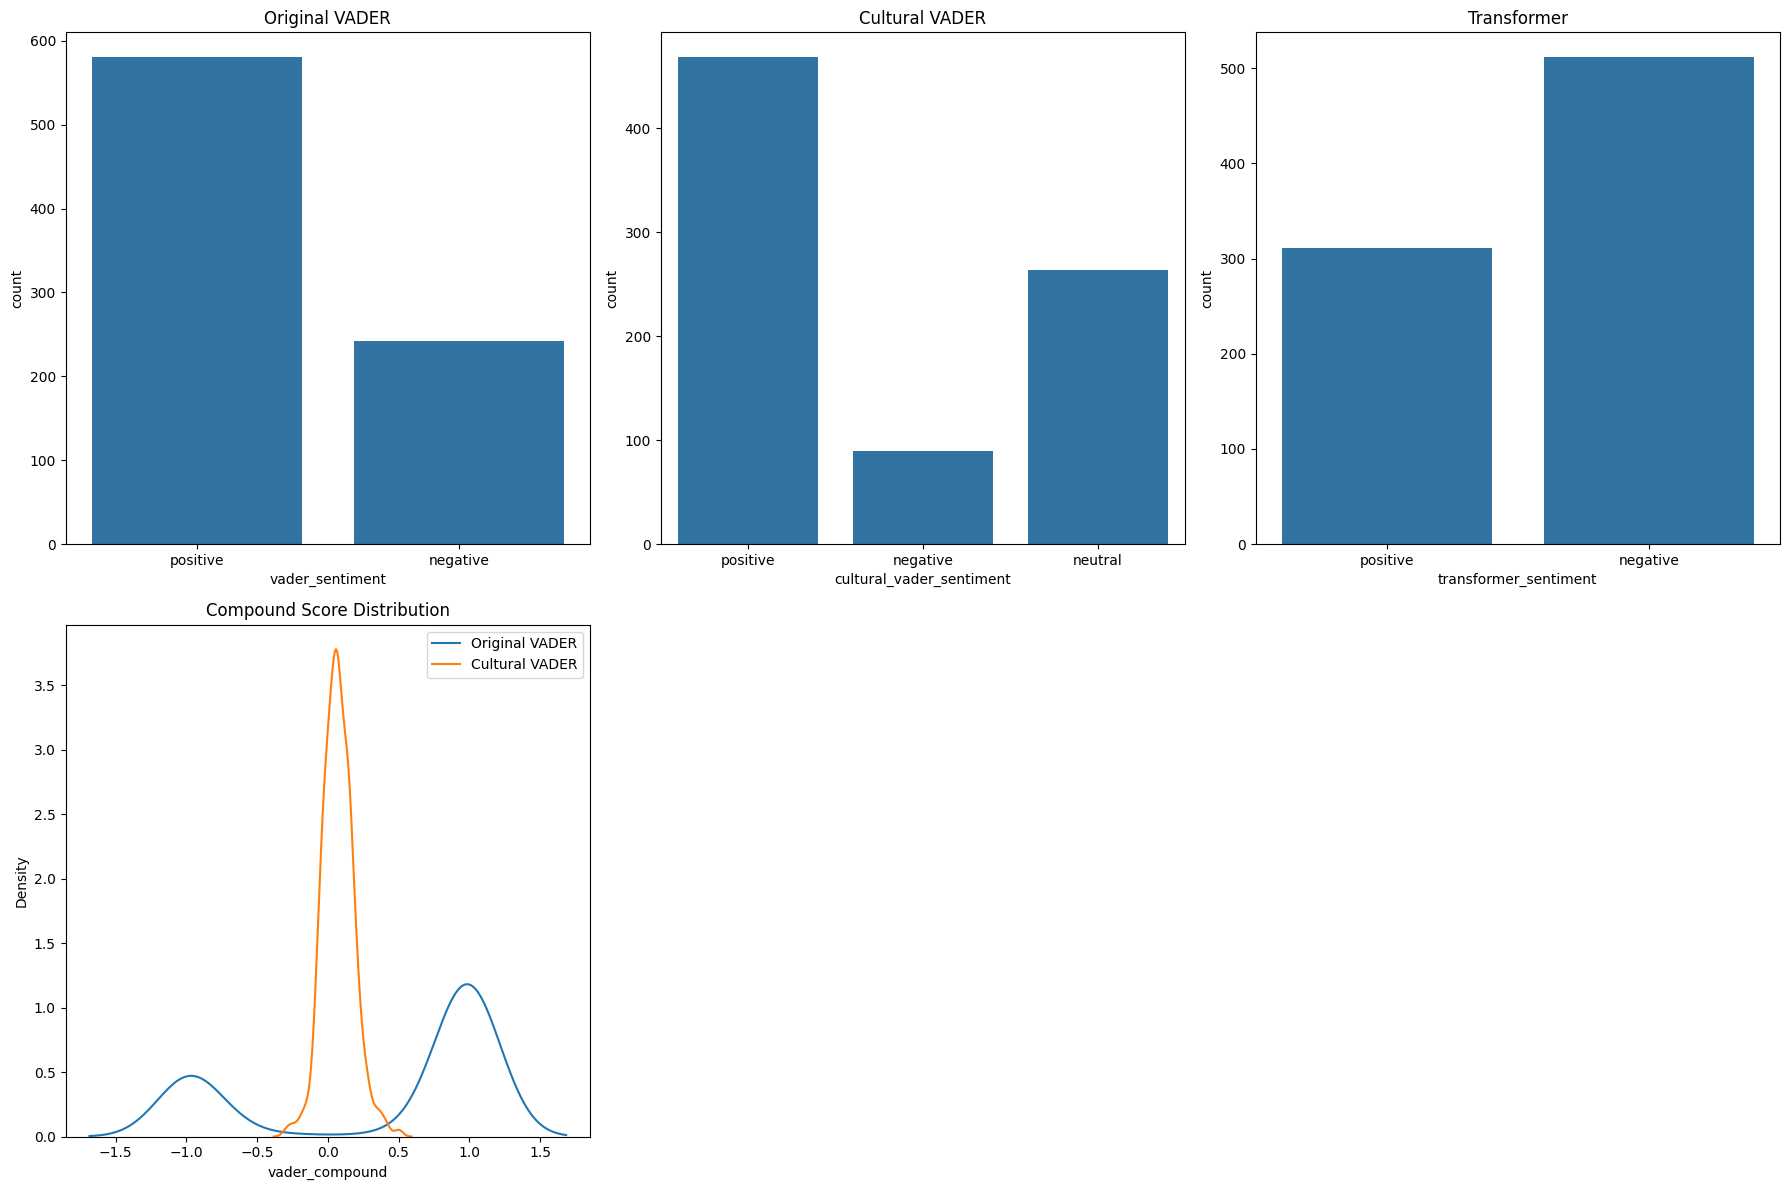

Original VADER vs Chinese Adapted VADER comparison:
cultural_vader_sentiment  negative  neutral  positive  Total
vader_sentiment                                             
negative                        90      148         4    242
positive                         0      116       465    581
Total                           90      264       469    823

Agreement between VADER and Transformer: 54.07%

Agreement between VADER and Cultural VADER: 37.79%

Agreement between Cultural VADER and Transformer: 37.79%
Results saved to '2VADER_Transformers.xlsx'


In [11]:
# Example usage
if __name__ == "__main__":
    # Replace with your file path and column name
    file_path = r"/content/3.Lyrics (en) .xlsx"
    lyrics_column = "lyrics"  # Change to your actual column name

    results = sentiment_analysis_pipeline(file_path, lyrics_column)

    if results is not None:
        # Save results to Excel
        results.to_excel("2VADER_Transformers.xlsx", index=False)
        print("Results saved to '2VADER_Transformers.xlsx'")